In [ ]:
# Global packages
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score, auc
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import models, transforms
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder

from PIL import Image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


# Loading in the Dataset

In [ ]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images
])

# Load the dataset
dataset = ImageFolder(root='../Dataset_BUSI_with_GT/', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (64, 64, 64)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 32, 32)
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (256, 16, 16)
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # (512, 8, 8)
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # (256, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (3, 128, 128)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Instantiate the AutoEncoder
model = AutoEncoder()
# Loss function and optimizer
epochs = 50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, _ in val_loader:
            outputs = model(images)
            loss = criterion(outputs, images)
            running_loss += loss.item()

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/50], Train Loss: 0.1320, Val Loss: 0.0516
Epoch [2/50], Train Loss: 0.0444, Val Loss: 0.0365
Epoch [3/50], Train Loss: 0.0296, Val Loss: 0.0248
Epoch [4/50], Train Loss: 0.0233, Val Loss: 0.0217
Epoch [5/50], Train Loss: 0.0211, Val Loss: 0.0197
Epoch [6/50], Train Loss: 0.0202, Val Loss: 0.0187
Epoch [7/50], Train Loss: 0.0185, Val Loss: 0.0172
Epoch [8/50], Train Loss: 0.0173, Val Loss: 0.0160
Epoch [9/50], Train Loss: 0.0163, Val Loss: 0.0154
Epoch [10/50], Train Loss: 0.0156, Val Loss: 0.0151
Epoch [11/50], Train Loss: 0.0146, Val Loss: 0.0136
Epoch [12/50], Train Loss: 0.0135, Val Loss: 0.0131
Epoch [13/50], Train Loss: 0.0132, Val Loss: 0.0124
Epoch [14/50], Train Loss: 0.0125, Val Loss: 0.0119
Epoch [15/50], Train Loss: 0.0135, Val Loss: 0.0121
Epoch [16/50], Train Loss: 0.0120, Val Loss: 0.0113
Epoch [17/50], Train Loss: 0.0113, Val Loss: 0.0108
Epoch [18/50], Train Loss: 0.0108, Val Loss: 0.0108
Epoch [19/50], Train Loss: 0.0105, Val Loss: 0.0102
Epoch [20/50], Train 

# Plot the loss

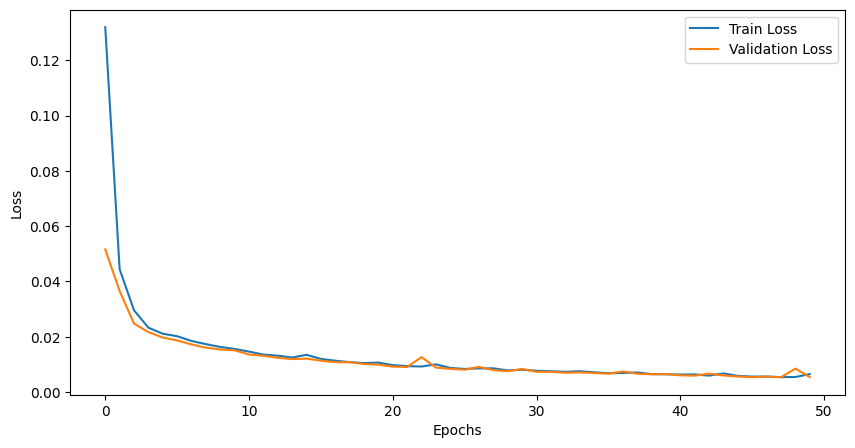

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the trained model
torch.save(model.state_dict(), './models/auto-encoder.pth')
print('Model saved to ./models/auto-encoder.pth')

Model saved to /content/drive/MyDrive/LU_ML MS thesis/Project/autoencoder_busi.pth


In [ ]:
# Load the model
model = AutoEncoder()
model.load_state_dict(torch.load('./models/auto-encoder.pth'))
print('Model loaded from ./models/auto-encoder.pth')

# Ensure the model is in evaluation mode
model.eval()

Model loaded from /content/drive/MyDrive/LU_ML MS thesis/Project/autoencoder_busi.pth


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
 

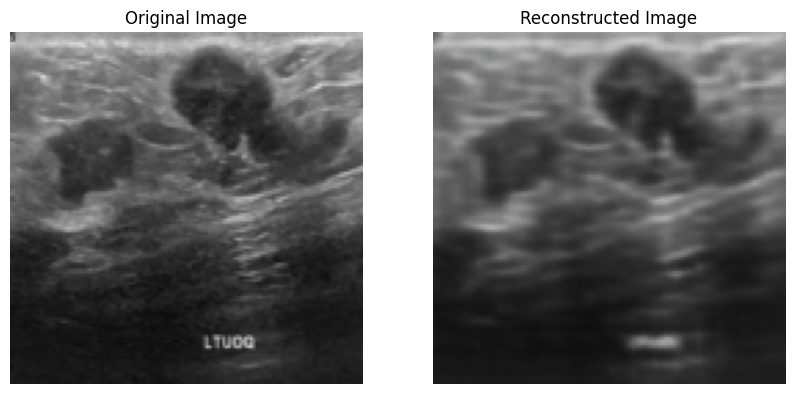

In [ ]:
# Function to display original and reconstructed images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a single image from the validation set
dataiter = iter(val_loader)
images, _ = next(dataiter)
image = images[6].unsqueeze(0)  # Get the first image and add a batch dimension

# Pass the image through the AutoEncoder
with torch.no_grad():
    reconstructed = model(image)

# Function to unnormalize and convert tensor to numpy array for plotting
def unnormalize(tensor):
    tensor = tensor / 2 + 0.5  # Unnormalize
    return tensor.squeeze().permute(1, 2, 0).numpy()

# Plot the original and reconstructed images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axs[0].imshow(unnormalize(image))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Reconstructed image
axs[1].imshow(unnormalize(reconstructed))
axs[1].set_title('Reconstructed Image')
axs[1].axis('off')

plt.show()